In [11]:
import numpy as np
import pandas as pd
from pandas import options
import warnings
options.mode.chained_assignment = None
import oandapyV20
import oandapyV20.endpoints.instruments as instruments
import matplotlib.dates as mpl_dates
import matplotlib.pyplot as plt
from mpl_finance import candlestick_ohlc
import datetime
import zulu
import os
pd.set_option('display.float_format', '{:.4f}'.format)
import operator as op
from functools import reduce
from sklearn.model_selection import ParameterGrid

ID = '101-004-9949998-001'
token = '4900a27fe17ab573d490ce234465329f-6633f44d08bf25b48ceaacd2c7917674'

client = oandapyV20.API(access_token=token)

In [2]:
# Loop to create the dataset
Date = pd.Series(datetime.datetime(2010, 1, 1, 0, 0, 0))
eurusd = pd.DataFrame()


while Date.iloc[-1].year != 2020 or Date.iloc[-1].month != 5:
    
    last = Date.iloc[-1]
    inizio = last + datetime.timedelta(minutes=5)
    inizio = zulu.create(inizio.year, inizio.month, inizio.day, inizio.hour, inizio.minute)
    inizio = inizio.isoformat('T')+'Z'
    inizio = str(inizio[:-8] + 'Z')

    params = {
            "from": inizio,
            "granularity": "M5"}

    r = instruments.InstrumentsCandles(instrument="EUR_USD",
                                       params=params)

    rv = client.request(r)

    newDat = []
    for oo in r.response['candles']:
        newDat.append([oo['time'], oo['mid']['o'], oo['mid']['h'], oo['mid']['l'], oo['mid']['c']])
    
    newEurusd = pd.DataFrame(newDat)
    newEurusd.columns = ['Time', 'Open', 'High', 'Low', 'Close']
    newEurusd["Time"] = pd.to_datetime(newEurusd['Time'])
    Date = Date.append(newEurusd['Time'])
    eurusd = eurusd.append(newEurusd)

In [12]:
#eurusd.to_csv(os.getcwd()+'\\eurusd5min.csv')
eurusd = pd.read_csv(os.getcwd()+'\\eurusd5min.csv', index_col=0)

### Long

In [13]:
# Due to my account equity, it's unrealistic that I will be able to average down my entry opening 30 trades
size=3000
sizeList = []
for i in range(7):
    sizeList.append(size)
    size = size*1.25

round(sum(sizeList),1)

45220.5

In [14]:
def Backtesting(emaPeriod, emaWidth, maxEntries, size, incrementSize, entryDistance, exit, data=eurusd):
    
    # Exponential Moving Averages
    data["ema40"] = data["Close"].ewm(span=emaPeriod, min_periods=emaPeriod, adjust=False).mean()
    deviation = emaWidth/100
    data["UL"] = data["ema40"] + (data["ema40"] * deviation)
    data["LL"] = data["ema40"] - (data["ema40"] * deviation)
    
    data = data.iloc[emaPeriod-1:]
    data.index = range(data.shape[0])
    
    data["buyTrigger"] = 0
    data["buyWin"] = 0 
    data["sellTrigger"] = 0 
    data["sellWin"] = 0 
    
    # Envelopes
    if exit=="greedy":
    
        data["buyTrigger"] = np.where(data["Close"] < data["LL"], 1,0)
        data["buyWin"] = np.where(data["Close"] > data["UL"], 1,0)
        data["sellTrigger"] = np.where(data["Close"] > data["UL"], 1,0)
        data["sellWin"] = np.where(data["Close"] < data["LL"], 1,0)
        
    elif exit=="spartan":

        data["buyTrigger"] = np.where(data["Close"] < data["LL"], 1,0)
        data["buyWin"] = np.where(data["Close"] > data["ema40"], 1,0)
        data["sellTrigger"] = np.where(data["Close"] > data["UL"], 1,0)
        data["sellWin"] = np.where(data["Close"] < data["ema40"], 1,0)
        
    
    eurusdBuy = data.drop(["sellTrigger","sellWin"], axis=1)
    eurusdSell = data.drop(["buyTrigger","buyWin"], axis=1)
    
    splits = np.append(np.where(np.diff(eurusdBuy["buyWin"]) != 0)[0]+1,len(eurusdBuy["buyWin"]))
    prev = 0
    price = []
    exit = []
    totSize = []
    tradeCount = []
    time = []
    totFees = []
    maxEntriesPerTrade = maxEntries
    totProfit = 0

    for split in splits[:-2]:
    
        indici = []
        indiciWhereBuy = []
        entryList = []
        sizeList = []
        fees = []
        sizePerTrade=size
    
        indici = np.arange(0,eurusdBuy["buyTrigger"].size,1)[prev:split]
        indiciWhereBuy = np.where(eurusdBuy["buyTrigger"].loc[indici]==1)[0]
        indiciWhereBuy = indiciWhereBuy + prev
        if len(indiciWhereBuy)>0:
            lastEntry = eurusdBuy["Close"].loc[indiciWhereBuy[0]] + (entryDistance+1)/10000
            countEntries = 0
            for i in range(len(indiciWhereBuy)-1):
                if eurusdBuy["Close"].loc[indiciWhereBuy[i+1]] < lastEntry - entryDistance/10000:
                    countEntries = countEntries + 1
                    if countEntries <= maxEntriesPerTrade:  
                        lastEntry = eurusdBuy["Close"].loc[indiciWhereBuy[i+1]]
                        sizePerTrade=sizePerTrade*incrementSize
                        entryList.append(lastEntry * sizePerTrade)
                        sizeList.append(sizePerTrade)
                        fees.append(sizePerTrade*0.00008)
                    else:
                        i = len(indiciWhereBuy)-1
        
            price.append(sum(entryList))
            totSize.append(sum(sizeList))
            tradeCount.append(len(entryList))
            exit.append(eurusdBuy["High"][split])
            totFees.append(sum(fees))
            time.append(eurusdBuy["Time"].loc[prev])
    
            prev = split
        
    data = {"Time": time, 'Price':price, 'Exit':exit, 'TradeExecuted':tradeCount, 'Size':totSize, "Fees":totFees}
    long = pd.DataFrame(data=data, index=range(len(time)))

    long = long[long["TradeExecuted"]!=0]

    long["AveragePrice"] = long["Price"]/long["Size"]
    long = long[["Time", "AveragePrice", 'Exit', 'TradeExecuted', 'Size', "Fees"]]
    long['Pips'] = (long["Exit"] - long["AveragePrice"])*10000
    long["P/L"] = long["Size"]*(long["Exit"] - long["AveragePrice"])-long["Fees"]
    
    totProfit = round(long["P/L"].sum())
        
    return long, totProfit

In [61]:
param_grid = {'emaPeriod': [21, 40, 200],
              'emaWidth': [0.15, 0.3],
              'maxEntries': [7], 
              'size' : [1000], 
              'incrementSize': [1.25], 
              'entryDistance' : [7],
              'exit': ['greedy', 'spartan']}

grid = ParameterGrid(param_grid)
comb = len(grid)
print('Number of parameters combination: '+ str(int(comb)))

Number of parameters combination: 12


In [62]:
PLdictionary = {}
z = 1

for params in grid:
    long, totProfit = Backtesting(params['emaPeriod'], 
                                  params['emaWidth'], 
                                  params['maxEntries'], 
                                  params['size'], 
                                  params['incrementSize'], 
                                  params['entryDistance'],
                                  params['exit'],
                                  data=eurusd)
    PLdictionary[z] = params
    PLdictionary[z]["PL"] = totProfit
    print(str(z) + ' of ' + str(int(int(comb))))
    z = z + 1

1 of 12
2 of 12
3 of 12
4 of 12
5 of 12
6 of 12
7 of 12
8 of 12
9 of 12
10 of 12
11 of 12
12 of 12


In [63]:
#Best performance
maxpl=0
for i in np.arange(1,len(PLdictionary)+1):
    pl = PLdictionary[i]["PL"]
    if pl>maxpl:
        maxpl = pl
        dictNumber = i
print(PLdictionary[dictNumber])

{'emaPeriod': 40, 'emaWidth': 0.15, 'entryDistance': 7, 'exit': 'spartan', 'incrementSize': 1.25, 'maxEntries': 7, 'size': 1000, 'PL': 1852.0}


In [65]:
long, totProfit = Backtesting(data=eurusd, emaPeriod=40, emaWidth=0.15, maxEntries=7, size=1000, incrementSize=1.25, 
                              entryDistance=7, exit='spartan')

In [66]:
long.head(5)

,Time,AveragePrice,Exit,TradeExecuted,Size,Fees,Pips,P/L
0,2010-01-03 21:05:00,1.4276,1.4292,3,4765.6250,0.3812,15.9754,7.2320
1,2010-01-04 02:50:00,1.4413,1.4438,1,1250.0000,0.1000,24.4000,2.9500
2,2010-01-05 09:50:00,1.4393,1.4423,1,1250.0000,0.1000,30.0000,3.6500
3,2010-01-05 15:00:00,1.4362,1.4373,3,4765.6250,0.3812,11.1000,4.9086
4,2010-01-05 21:25:00,1.4336,1.4359,1,1250.0000,0.1000,22.6000,2.7250


In [67]:
#long.to_csv(os.getcwd()+'\\eurusd_long.csv')
long = pd.read_csv(os.getcwd()+'\\eurusd_long.csv', index_col=0)

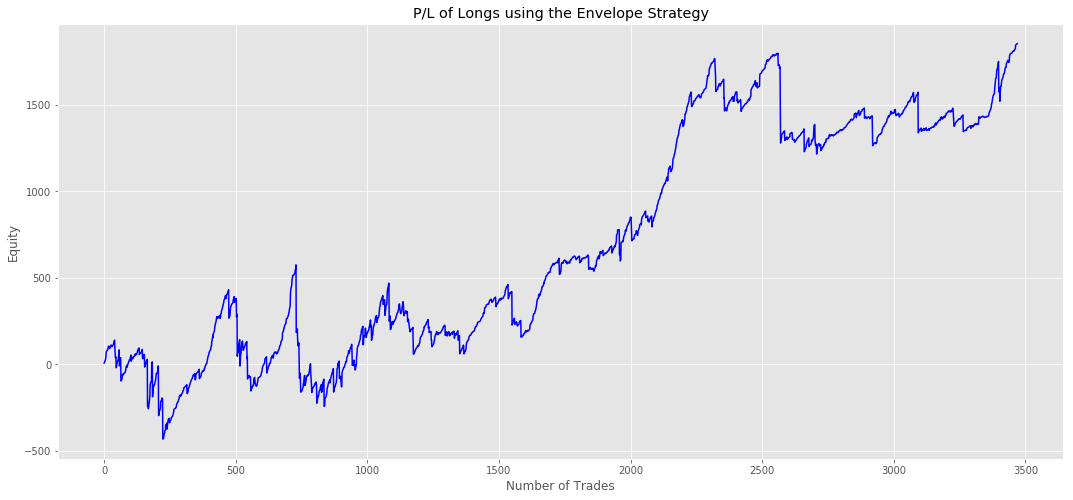

In [68]:
import matplotlib.pyplot as plt
 
plt.style.use('ggplot')

PL = pd.Series(np.cumsum(long["P/L"]))


plt.figure(figsize=(18, 8), facecolor='w', edgecolor='k');
PL.plot(color='blue');
plt.title("P/L of Longs using the Envelope Strategy", loc='center', pad=None)
plt.ylabel("Equity");
plt.xlabel("Number of Trades");
plt.rcParams.update({'font.size': 30})

## Stats

In [69]:
long["Time"].loc[long["TradeExecuted"].idxmax()]

'2010-01-15 12:35:00'

In [70]:
long["P/L"].loc[long["P/L"].idxmax()]

104.41875610351441

In [71]:
long["P/L"].loc[long["P/L"].idxmin()]

-439.5746063232426

In [72]:
countEntries = long.groupby("TradeExecuted")["P/L"].count()
avgPL = long.groupby("TradeExecuted")["P/L"].mean()
avgPL = round(avgPL,1)
data = {"Count": countEntries, "P/L": avgPL}
stats=pd.DataFrame(data)
stats

,Count,P/L
TradeExecuted,,
1,1071,2.5000
2,587,4.7000
3,386,6.6000
4,245,7.1000
5,149,8.1000
6,85,7.6000
7,204,-47.5000


In [74]:
import matplotlib.pyplot as plt
 
plt.style.use('ggplot')

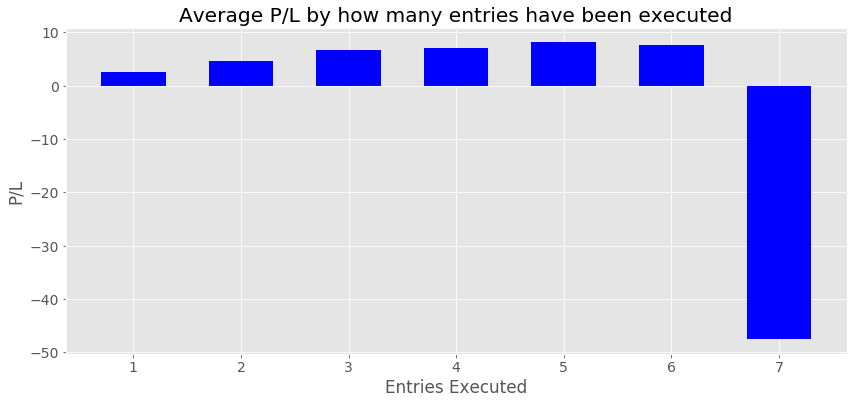

In [76]:
plt.figure(figsize=(14, 6))
# Create bars
ind = np.arange(len(stats)) 
plt.bar(ind ,stats["P/L"], color="blue", width=0.6)

plt.xticks(ind, ('1', '2', '3', '4', '5','6', '7'))
plt.xlabel("Entries Executed")
plt.ylabel("P/L")
plt.title("Average P/L by how many entries have been executed")

plt.rcParams.update({'font.size': 14})

# Show graphic
plt.show()


In [77]:
positive = long[long["P/L"]>0]
positive = positive.groupby("TradeExecuted")["P/L"].mean()
positive

TradeExecuted
1    2.5485
2    5.1725
3    7.6182
4    9.6958
5   15.8569
6   15.3437
7   25.3229
Name: P/L, dtype: float64

In [78]:
negative = long[long["P/L"]<0]
negative = negative.groupby("TradeExecuted")["P/L"].mean()
negative

TradeExecuted
1    -0.6517
2    -1.2786
3    -2.8608
4    -3.8458
5    -7.1293
6   -12.0294
7   -66.9100
Name: P/L, dtype: float64

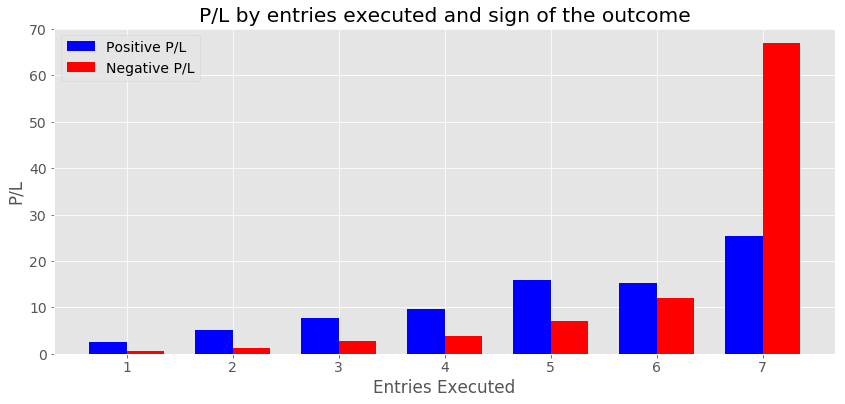

In [79]:
plt.figure(figsize=(14, 6))
ind = np.arange(len(positive)) 
width = 0.35       
plt.bar(ind, positive, width, label='Positive P/L', color="blue")
plt.bar(ind + width, abs(negative), width, label='Negative P/L', color="red")

plt.ylabel('P/L')
plt.xlabel("Entries Executed")
plt.title('P/L by entries executed and sign of the outcome')

plt.xticks(ind + width / 2, ('1', '2', '3', '4', '5','6', '7'))
plt.legend(loc='best')

plt.rcParams.update({'font.size': 14})

plt.show()